In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt

DIR_val_train = "Encode_data/ang_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/ang_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/ang_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/ang_enc_data_set_test_classes.csv"

# Circuito

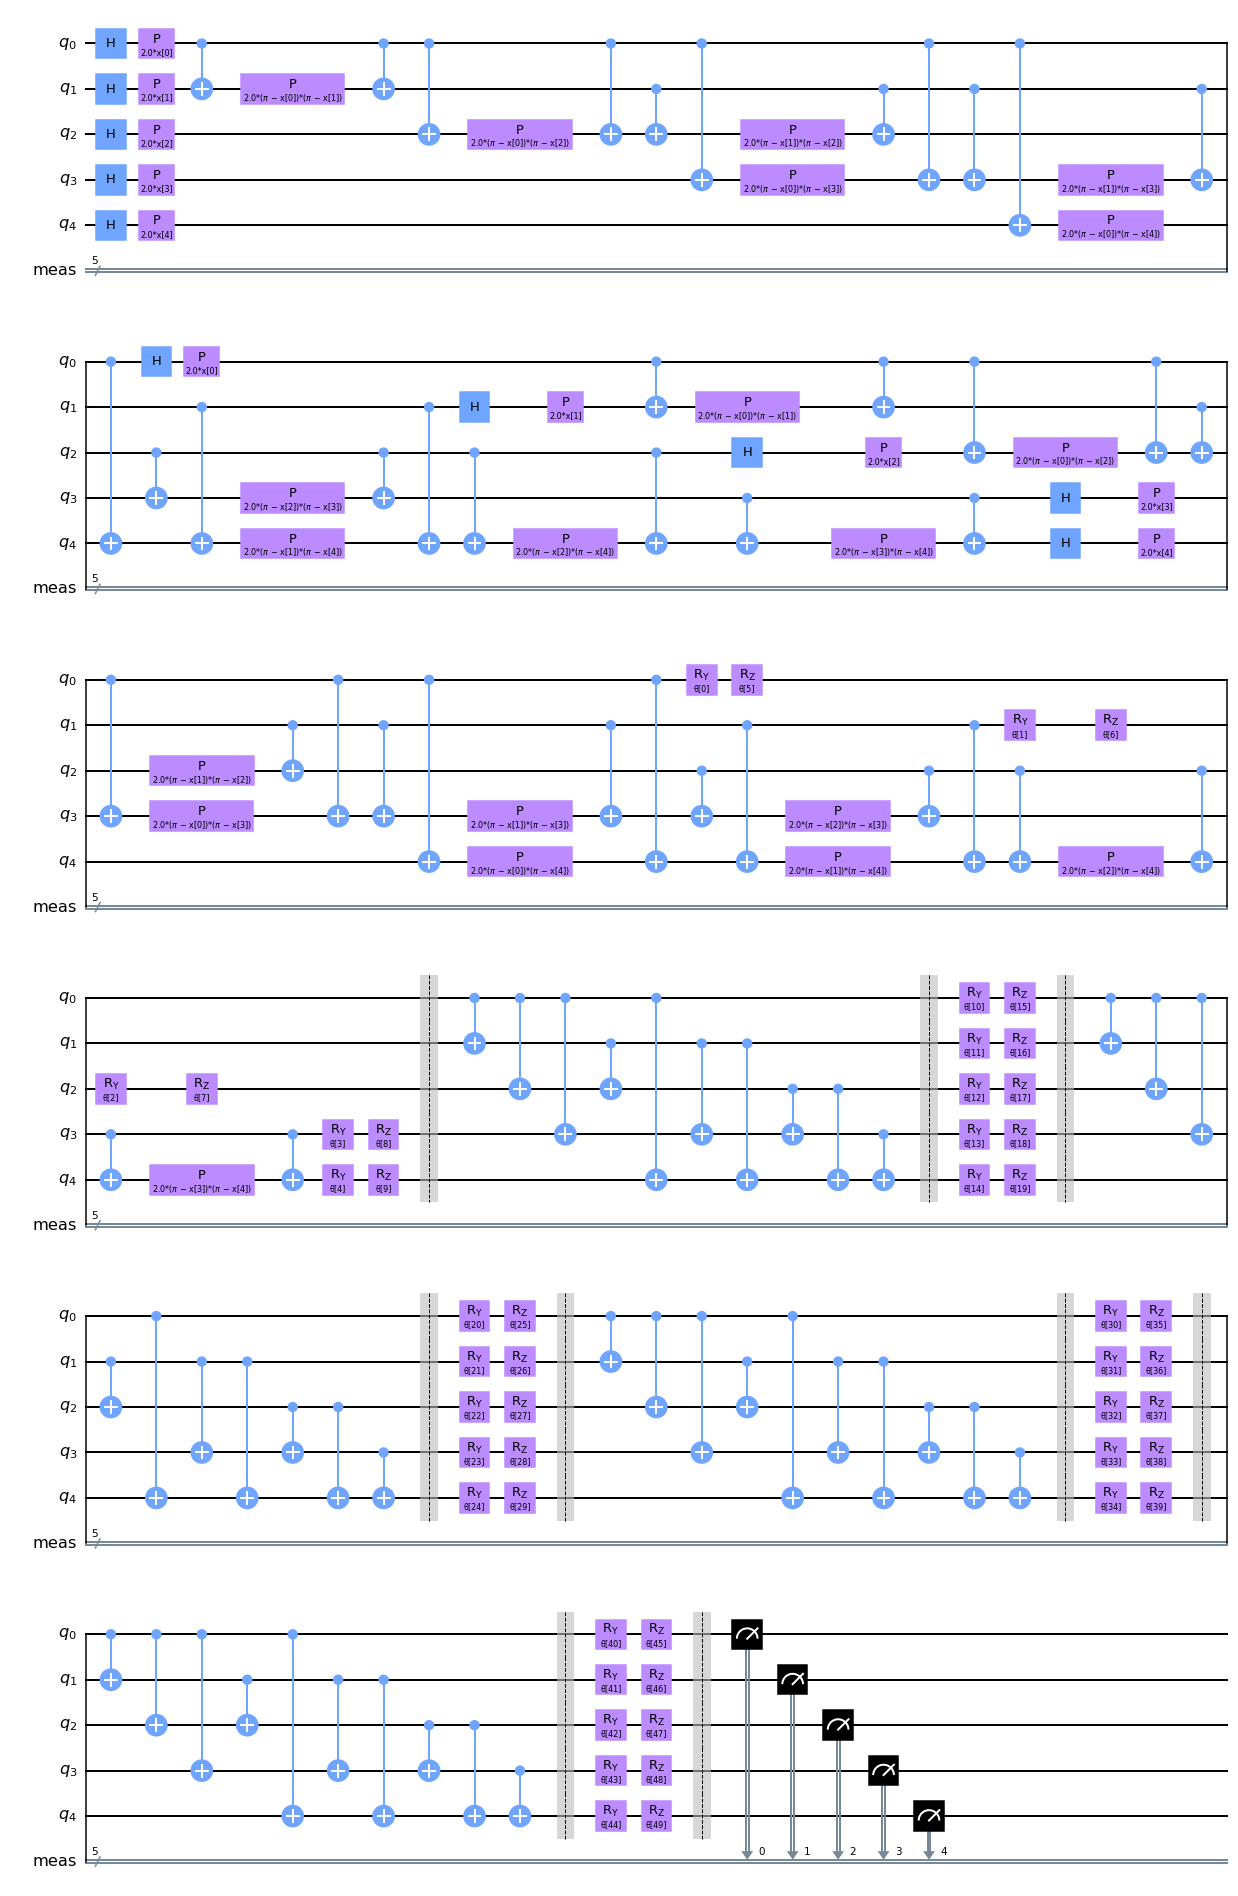

In [2]:
n_qubits = 5

encoding = ZZFeatureMap(feature_dimension=n_qubits, reps=2)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")
qc = encoding.compose(ansatz)
qc.measure_all()
qc.decompose().draw(output="mpl")

In [3]:
train_data = np.genfromtxt(DIR_val_train, delimiter=";")
train_labels = np.genfromtxt(DIR_cls_train, delimiter=";")

test_data = np.genfromtxt(DIR_val_test, delimiter=";")
test_labels = np.genfromtxt(DIR_cls_test, delimiter=";")

In [4]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [5]:

def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [6]:
train_labels_oh = train_labels
test_labels_oh = test_labels

In [7]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [classification(results.get_counts(c)) for c in circuits]
    #print(predictions)
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [8]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        #print(prob, state)
        exp_val += ((-1)**(count_ones(state)%2))*prob
    
    #print(f"Valor expectávlel {exp_val}, Label {label_assign(exp_val)} ")
    if label:
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    #print(f"Loss {y}-{y_hat}**2")
    #print(f"Loss {(y-y_hat)**2}")
    return (y-y_hat) * (y-y_hat)

In [9]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost 2.3
Cost 2.1
Cost 1.85
Cost 1.6
Cost 1.65
Cost 2.4
Cost 1.85
Cost 1.8
Cost 1.75
Cost 2.35
Cost 2.0
Cost 1.75
Cost 1.85
Cost 2.1
Cost 1.55
Cost 2.05
Cost 1.8
Cost 1.55
Cost 2.25
Cost 1.65
Cost 1.75
Cost 2.15
Cost 1.9
Cost 2.2
Cost 2.45
Cost 1.85
Cost 2.35
Cost 2.15
Cost 1.85
Cost 2.45
Cost 1.9
Cost 1.9
Cost 2.2
Cost 2.05
Cost 1.6
Cost 2.1
Cost 1.6
Cost 2.15
Cost 1.95
Cost 2.05
Cost 2.1
Cost 2.2
Cost 1.95
Cost 2.3
Cost 1.75
Cost 2.1
Cost 2.2
Cost 1.9
Cost 1.75
Cost 1.85
Cost 2.1
Cost 1.85
Cost 1.9
Cost 2.15
Cost 2.0
Cost 2.0
Cost 1.65
Cost 2.05
Cost 2.4
Cost 2.05
Cost 2.6
Cost 1.8
Cost 1.4
Cost 2.25
Cost 2.3
Cost 2.4
Cost 2.6
Cost 2.4
Cost 2.15
Cost 2.2
Cost 2.3
Cost 2.35
Cost 2.4
Cost 2.15
Cost 2.2
Cost 2.35
Cost 2.15
Cost 2.25
Cost 2.35
Cost 2.3
Cost 2.15
Cost 2.1
Cost 2.15
Cost 2.45
Cost 2.3
Cost 2.2
Cost 2.35
Cost 1.85
Cost 2.0
Cost 2.1
Cost 1.65
Cost 1.6
Cost 1.7
Cost 1.85
Cost 1.7
Cost 1.75
Cost 1.45
Cost 1.6
Cost 1.75
Cost 1.6
Cost 1.6
Cost 1.55
Cost 1.75
Cost 1.5
Cost 1.8
Co

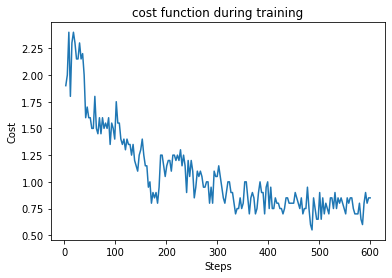

In [10]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [11]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    #print(circuits)

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    prediction = [classification(results.get_counts(c)) for c in circuits]
    print(f"Predictions: {prediction}")
    print(f"Labels: {labels}")
    #prediction = [0 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [12]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

Predictions: [-1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1]
Labels: [-1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.]
Test set accuracy - 0.4583333333333333


## Cross Entropy Loss

### Parity method

In [13]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [14]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    #print(y_hat)
    return np.sum(y*np.log(y_hat))

In [15]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]

    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [16]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost: 0.7382063964561361
Cost: 0.7102003429298657
Cost: 0.7278575805047067
Cost: 0.7513444609317782
Cost: 0.7167830057847345
Cost: 0.7114324887109765
Cost: 0.7104996940373989
Cost: 0.7019654279432219
Cost: 0.7113687409487969
Cost: 0.7190549011740786
Cost: 0.7380525531997331
Cost: 0.6844962407091909
Cost: 0.7439641524571742
Cost: 0.711223163844289
Cost: 0.7024391688810415
Cost: 0.690933254613826
Cost: 0.7592691800157686
Cost: 0.7007053877457318
Cost: 0.7084878726397296
Cost: 0.722094788455613
Cost: 0.7338056045507508
Cost: 0.7068206724631908
Cost: 0.7700414155420183
Cost: 0.7418586347344255
Cost: 0.733569646312945
Cost: 0.6989546442041802
Cost: 0.763441035053698
Cost: 0.7478084440811188
Cost: 0.7389370616828697
Cost: 0.6870641089255433
Cost: 0.7633102677925476
Cost: 0.7349301671031807
Cost: 0.6841436636828814
Cost: 0.7257964476256139
Cost: 0.7326364375562472
Cost: 0.7650343021259323
Cost: 0.7015023635008129
Cost: 0.7235944579824574
Cost: 0.7362877318352483
Cost: 0.719058335242121
Cost: 

Cost: 0.5490007531046596
Cost: 0.5099199584244609
Cost: 0.527918611547225
Cost: 0.5358451701147516
Cost: 0.5207125432464885
Cost: 0.5364530066329446
Cost: 0.5340402211356304
Cost: 0.5117893338104689
Cost: 0.5265336587374698
Cost: 0.5459445683740305
Cost: 0.510117992919635
Cost: 0.5208402811458746
Cost: 0.5343232460707151
Cost: 0.5136323413453789
Cost: 0.5324359818504849
Cost: 0.5303107756527192
Cost: 0.5141407713172836
Cost: 0.5230211805675118
Cost: 0.5421503018485371
Cost: 0.5102445249679386
Cost: 0.5401415951953995
Cost: 0.5178660495452855
Cost: 0.5069708406041779
Cost: 0.5242033738775046
Cost: 0.5403129313003883
Cost: 0.5085492688948676
Cost: 0.5126644273519902
Cost: 0.538190216486473
Cost: 0.505764497041198
Cost: 0.5144872830262818
Cost: 0.5300523347741206
Cost: 0.504122737565245
Cost: 0.5257829251872123
Cost: 0.5196907382903886
Cost: 0.5037889583253141
Cost: 0.5232703314972571
Cost: 0.5239028398999036
Cost: 0.5062202785251749
Cost: 0.5293595952404627
Cost: 0.528770500138474
Cost: 

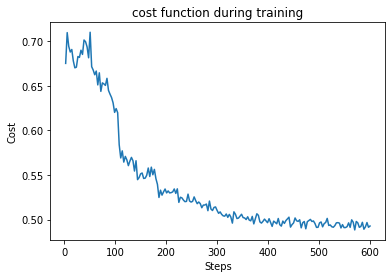

In [17]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [18]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(prediction)
    print(labels)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [19]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[-1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1]
[-1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.]
Test set accuracy - 0.6666666666666666


In [20]:
print(len(train_data))

80


In [21]:
print(train_data)

[[ 3.91720245e+02  1.00521079e+01  3.14159265e+00  3.28301029e+00
   8.48656974e+00]
 [ 3.14159265e+00 -3.25425638e-01 -1.80057013e-01 -1.36102931e-02
   3.34769871e-02]
 [ 1.30579521e+03  8.76004080e+00  4.96059173e+00  3.14159265e+00
   3.43772836e+01]
 [ 3.14159265e+00  7.07779755e-01 -1.83877476e-02  2.70830243e-03
  -3.41257582e-02]
 [-3.62222025e+02  3.14159265e+00 -3.30871702e+00 -1.51094377e+01
   2.82111391e+00]
 [ 3.14159265e+00 -2.92655827e+00  1.58640292e-01 -3.15289230e-01
  -1.05613034e-01]
 [-1.78748436e+02 -5.42503891e-01 -6.47846852e-01 -2.84266110e+00
   3.14159265e+00]
 [-9.34414140e+02 -3.57440605e+00  3.14159265e+00  2.16944059e+00
  -4.63864321e+00]
 [-8.38017002e+00  3.14159265e+00 -5.46470672e-01 -4.83541627e-01
   3.39867934e-01]
 [ 3.14159265e+00 -2.28902368e-01 -2.83311402e-01 -7.70220221e-02
  -1.02837722e-02]
 [ 3.14159265e+00 -1.34306202e+01  6.02144318e-01  7.88796050e-01
   2.17124442e-01]
 [ 3.14159265e+00 -4.18348204e-02  3.28291381e-02 -1.55366741e-02